### Importing dependancies

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### 1. Get data using pandas_datareader

In [2]:
ticker = "AMZN"

df = pdr.get_data_yahoo(ticker)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-03,3074.899902,2980.979980,3018.530029,3048.409912,4897900,3048.409912
2020-11-04,3244.850098,3139.729980,3159.989990,3241.159912,6839000,3241.159912
2020-11-05,3366.800049,3288.879883,3319.969971,3322.000000,5789300,3322.000000
2020-11-06,3322.000000,3232.000000,3304.639893,3311.370117,4641300,3311.370117
2020-11-09,3289.000000,3112.105713,3231.030029,3169.469971,6090798,3169.469971


#### Plotting the closing price 

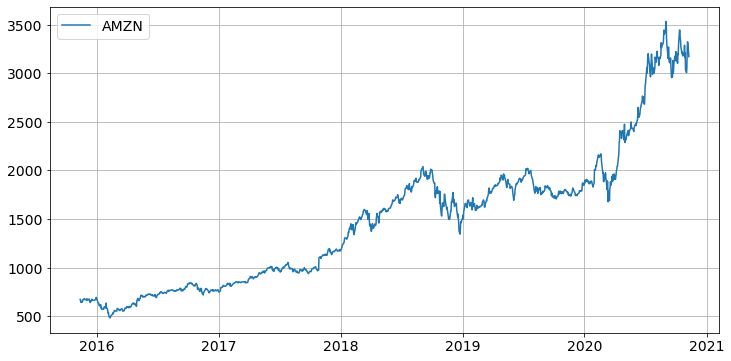

In [3]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["font.size"] = 14

df1 = df.reset_index()["Close"]

plt.plot(df.index,df1, label="{}".format(ticker))
plt.legend()
plt.grid(True)
plt.show()

### 2. Data Preprocessing 

#### Scaling the data to (0,1) range as LSTMs are known to be sensitive to the scale of the data

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# df1[:5]

#### In case of a time series it's ideal to split the data into training and testing sets

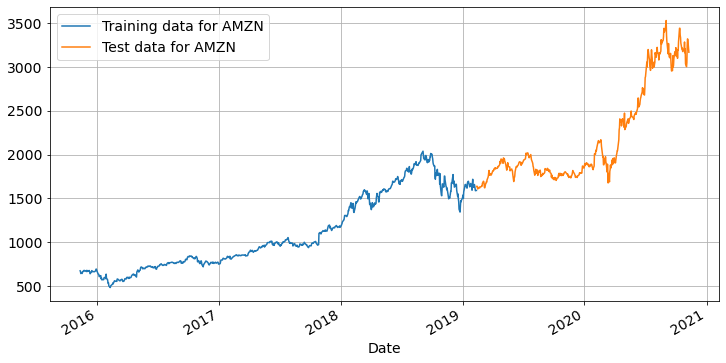

In [5]:
percentage_training_data = 0.65

train_data = df1[:int(percentage_training_data*df.shape[0])]

test_data = df1[int(percentage_training_data*df.shape[0]):]

# Plot the training and test values of closing price 
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["font.size"] = 14

df["Close"][:int(percentage_training_data*df.shape[0])].plot(label="Training data for {}".format(ticker))
df["Close"][int(percentage_training_data*df.shape[0]):].plot(label="Test data for {}".format(ticker))
plt.legend(); plt.grid(True); plt.show()

#### Create features and target variables based on timesteps

In [17]:
def create_features_targets(data, timesteps):
    features = []
    target = []
    for i in range(len(data)-timesteps-1):
        features.append(list(data[i:i+timesteps]))
        target.append(data[i+timesteps])
    return np.array(features), np.array(target)

timesteps = 30

X_train, y_train = create_features_targets(train_data, timesteps=timesteps)

X_test, y_test = create_features_targets(test_data, timesteps=timesteps)

### 3. Create a stacked LSTM model

In [18]:
## Reshaping input for LSTM as : [sample_size, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
## Creating the stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(timesteps,
               return_sequences=True,
               input_shape=(timesteps, 1)))

model.add(LSTM(timesteps))
model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [20]:
## Fit the model
model = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs=100, 
          batch_size=50, 
          verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 164ms/step - loss: 0.0298 - val_loss: 0.0398
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0028 - val_loss: 0.0310
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 9.5579e-04 - val_loss: 0.0015
Epoch 6/100
8/8 [==============================] - 0s 19ms/step - loss: 4.9376e-04 - val_loss: 0.0025
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 4.3387e-04 - val_loss: 0.0017
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 4.2711e-04 - val_loss: 0.0014
Epoch 9/100
8/8 [==============================] - 0s 23ms/step - loss: 3.8364e-04 - val_loss: 0.0015
Epoch 10/100
8/8 [==============================] - 0s 24ms/step - loss: 3.5264e-04 - val_loss: 0

Epoch 81/100
8/8 [==============================] - 0s 23ms/step - loss: 2.2520e-04 - val_loss: 0.0037
Epoch 82/100
8/8 [==============================] - 0s 23ms/step - loss: 2.2284e-04 - val_loss: 0.0031
Epoch 83/100
8/8 [==============================] - 0s 22ms/step - loss: 2.2505e-04 - val_loss: 0.0028
Epoch 84/100
8/8 [==============================] - 0s 23ms/step - loss: 2.2040e-04 - val_loss: 0.0031
Epoch 85/100
8/8 [==============================] - 0s 20ms/step - loss: 2.1964e-04 - val_loss: 0.0033
Epoch 86/100
8/8 [==============================] - 0s 20ms/step - loss: 2.1805e-04 - val_loss: 0.0032
Epoch 87/100
8/8 [==============================] - 0s 19ms/step - loss: 2.1844e-04 - val_loss: 0.0032
Epoch 88/100
8/8 [==============================] - 0s 18ms/step - loss: 2.1657e-04 - val_loss: 0.0029
Epoch 89/100
8/8 [==============================] - 0s 19ms/step - loss: 2.1580e-04 - val_loss: 0.0027
Epoch 90/100
8/8 [==============================] - 0s 19ms/step - loss: 

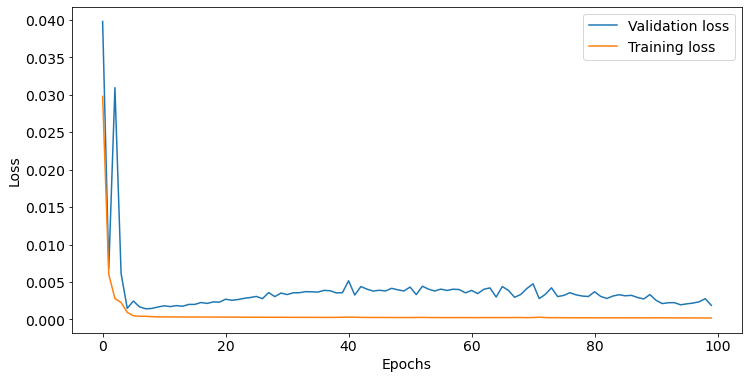

In [21]:
plt.plot(model.history["val_loss"], label="Validation loss")
plt.plot(model.history["loss"], label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 4. Predict the output for test data

In [22]:
## Model predictions on test data
train_predictions = model.model.predict(X_train)
test_predictions = model.model.predict(X_test)

In [23]:
## Tranforming predictions back to original values
train_predictions = scaler.inverse_transform(train_predictions) 
test_predictions = scaler.inverse_transform(test_predictions)

In [24]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Training MSE",math.sqrt(mean_squared_error(y_train,train_predictions)))
print("Training MAE",math.sqrt(mean_absolute_error(y_train,train_predictions)))

print("Testing MSE",math.sqrt(mean_squared_error(y_test, test_predictions)))
print("Testing MAE",math.sqrt(mean_absolute_error(y_test, test_predictions)))

Training MSE 1200.4086349257523
Training MAE 33.51274866442122
Testing MSE 2218.1538109202183
Testing MAE 46.55972274257913


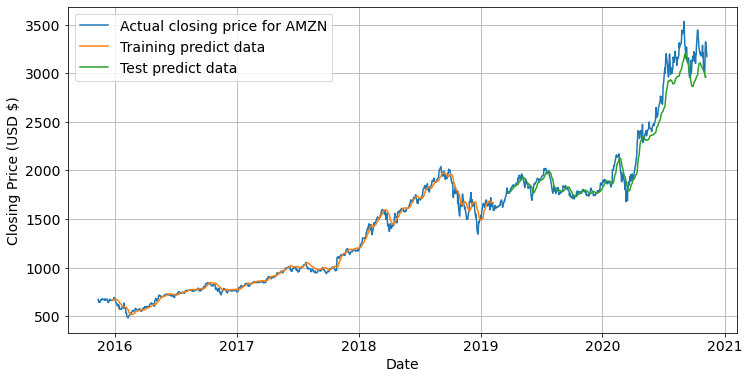

In [25]:
### Plotting 
# shift train predictions for plotting
look_back=timesteps
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predictions)+look_back, :] = train_predictions
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predictions)+(look_back*2)+1:len(df1)-1, :] = test_predictions
# plot baseline and predictions
plt.plot(df.index, scaler.inverse_transform(df1), label = "Actual closing price for {}".format(ticker))
plt.plot(df.index, trainPredictPlot, label = "Training predict data")
plt.plot(df.index, testPredictPlot, label = "Test predict data")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD $)")
plt.legend()
plt.grid(True)
plt.show()

### 5. Predict closing price for the next 1 month

In [39]:
x_input = test_data[len(test_data)-timesteps:].reshape(1,-1)

temp_input = list(x_input)[0].tolist()

lst_output=[]
n_steps=timesteps
i=0

days_ahead = 5

while(i<days_ahead):
    
    if(len(temp_input)>timesteps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

future = scaler.inverse_transform(lst_output)

df_prediction = pd.concat([pd.DataFrame([df.index.max()+datetime.timedelta(i+1) for i in range(days_ahead)],
                                        columns=["Date"]), 
                           pd.DataFrame(future,
                                        columns=["Prediction"])], axis=1).set_index("Date")

final_df_with_prediction = pd.concat([df, df_prediction])

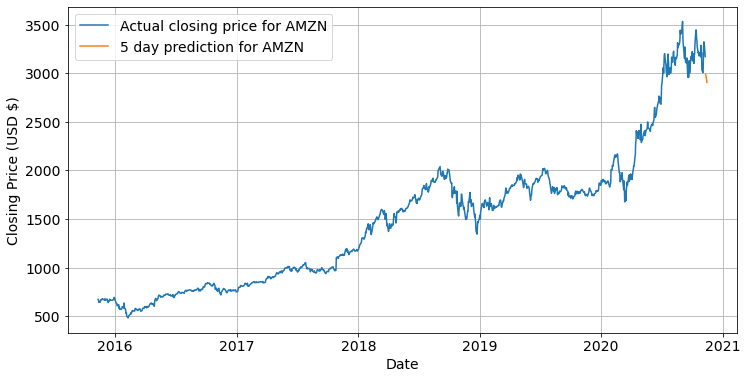

In [40]:
plt.plot(final_df_with_prediction["Close"],  label = "Actual closing price for {}".format(ticker))
plt.plot(final_df_with_prediction["Prediction"],  label = "{} day prediction for {}".format(days_ahead,ticker))
plt.xlabel("Date")
plt.ylabel("Closing Price (USD $)")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
final_df_with_prediction

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2015-11-11,675.960022,663.250000,663.250000,673.250000,5387300.0,673.250000,NaN
2015-11-12,675.640015,664.219971,673.000000,665.599976,4284700.0,665.599976,NaN
2015-11-13,667.000000,640.450012,663.570007,642.349976,6261100.0,642.349976,NaN
2015-11-16,649.989990,622.289978,640.919983,647.809998,7435900.0,647.809998,NaN
2015-11-17,653.250000,641.000000,650.650024,643.299988,4320200.0,643.299988,NaN
...,...,...,...,...,...,...,...
2020-11-10,NaN,NaN,NaN,NaN,NaN,NaN,2987.233063
2020-11-11,NaN,NaN,NaN,NaN,NaN,NaN,2976.225665
2020-11-12,NaN,NaN,NaN,NaN,NaN,NaN,2957.069727
